<h1>Mini Project On Electric Vehicle Population</h1>

<h2>Data Set : Electric Vehicle Population Data</h2>

<h3>Source : https://catalog.data.gov/dataset?q=&sort=views_recent+desc</h3>

# Electric Vehicle Population Analysis (PySpark)
Notebook created to load, clean, explore, aggregate and save analyses of Electric_Vehicle_Population_Data.csv
Reference structure adapted from the provided PDF. :contentReference[oaicite:1]{index=1}

In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

**Dataset Insights: Electric Vehicle Population Data**

The dataset provides detailed information about electric vehicles (EVs) registered across various states and counties in the U.S. It contains **261,698 records** with **17 attributes**, offering a comprehensive view of EV adoption trends, manufacturer presence, and vehicle characteristics.

---

### 1. Structure and Uniqueness

* The dataset has **261,698 rows × 17 columns**.
* Each vehicle is uniquely identified by a `DOL Vehicle ID`.
* `VIN (1-10)` offers partial vehicle identification, with ~15,753 unique values.
* There are **46 makes** and **181 models**, reflecting diversity in the EV market.
* Coverage spans **52 states**, **236 counties**, and **854 cities**, capturing wide geographic adoption.

---

### 2. Geographic Distribution

* The dataset highlights EV penetration across the U.S., with significant clustering in certain counties and states.
* Over **1,000 postal codes** are represented, providing fine-grained location detail.
* Geographic spread indicates that EV adoption is not confined to one region but distributed, with urban counties often having higher concentrations.

---

### 3. Model Year Trends

* EVs range from **model year 2000 to 2026**, with an average around **2021–2022**.
* Recent years (2020–2024) dominate registrations, confirming accelerating EV adoption.
* Earlier years show sparse entries, mostly pilot models or early adopters.

---

### 4. Vehicle Types and Eligibility

* Two categories of EVs are captured: **Battery Electric Vehicles (BEV)** and **Plug-in Hybrid Electric Vehicles (PHEV)**.
* CAFV (Clean Alternative Fuel Vehicle) eligibility includes three labels, highlighting policy-driven classification of vehicles.

---

### 5. Electric Range

* The `Electric Range` varies from **0 to 337 miles**.
* Many entries have **0 range**, likely representing hybrids where range is not fully electric.
* Median range is **35 miles**, aligning with common PHEV designs.
* BEVs dominate the higher range spectrum, reflecting advances in battery technology.

---

### 6. Pricing (Base MSRP)

* `Base MSRP` ranges from **$0 to $845,000**, though many values are missing or default to 0.
* High outliers represent luxury or specialized EVs.
* For most EVs, MSRP clusters in the typical consumer vehicle price bands.

---

### 7. Legislative and Census Information

* Each entry is mapped to **Legislative Districts** (1–49) and **2020 Census Tracts**, enabling policy-level and demographic analysis.
* Some missing values exist in `Legislative District` and `Vehicle Location`, but overall data completeness is strong.

---

### 8. Key Relationships

* **Model Year vs. Range**: Newer vehicles tend to have higher ranges, reflecting battery improvements.
* **Make vs. Adoption**: A handful of manufacturers (e.g., Tesla, Nissan, Chevrolet) dominate the dataset, though diversity is increasing.
* **State vs. EV Count**: Certain states emerge as leaders in EV registrations, often due to supportive policies and infrastructure.

---

### 9. Workforce & Market Characteristics

The dataset paints a picture of a rapidly expanding EV market in the U.S., characterized by:

* Strong geographic spread
* Growing dominance of BEVs over PHEVs
* Increasing model variety and year-on-year growth
* Clear policy and infrastructure influence (CAFV eligibility, legislative mapping)

---

In [3]:
input_path = "file:///C:/Users/muvva/Downloads/Electric_Vehicle_Population_Data.csv"

df = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .csv(input_path)

print("Rows:", df.count())
df.printSchema()
df.show(5, truncate=False)

Rows: 261698
root
 |-- VIN (1-10): string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal Code: integer (nullable = true)
 |-- Model Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric Vehicle Type: string (nullable = true)
 |-- Clean Alternative Fuel Vehicle (CAFV) Eligibility: string (nullable = true)
 |-- Electric Range: integer (nullable = true)
 |-- Base MSRP: integer (nullable = true)
 |-- Legislative District: integer (nullable = true)
 |-- DOL Vehicle ID: integer (nullable = true)
 |-- Vehicle Location: string (nullable = true)
 |-- Electric Utility: string (nullable = true)
 |-- 2020 Census Tract: long (nullable = true)

+----------+--------+------------+-----+-----------+----------+------+-------+--------------------------------------+------------------------------------------------------------+--------------+---------

In [4]:
old_cols = df.columns

# mapping - adjust if your column names differ slightly
renames = {
    'VIN (1-10)': 'vin',
    'County': 'county',
    'City': 'city',
    'State': 'state',
    'Postal Code': 'postal_code',
    'Model Year': 'model_year',
    'Make': 'make',
    'Model': 'model',
    'Electric Vehicle Type': 'ev_type',
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility': 'cafv_eligibility',
    'Electric Range': 'electric_range',
    'Base MSRP': 'base_msrp',
    'Legislative District': 'legislative_district',
    'DOL Vehicle ID': 'dol_vehicle_id',
    'Vehicle Location': 'vehicle_location',
    'Electric Utility': 'electric_utility',
    '2020 Census Tract': 'census_tract'
}

for o,n in renames.items():
    if o in df.columns:
        df = df.withColumnRenamed(o, n)

print("Columns after rename:", df.columns)

Columns after rename: ['vin', 'county', 'city', 'state', 'postal_code', 'model_year', 'make', 'model', 'ev_type', 'cafv_eligibility', 'electric_range', 'base_msrp', 'legislative_district', 'dol_vehicle_id', 'vehicle_location', 'electric_utility', 'census_tract']


In [6]:
from pyspark.sql.functions import col, when, sum as _sum
from pyspark.sql.types import StringType, NumericType

n = df.count()

null_exprs = []
for c, dtype in df.dtypes:
    if dtype in ("string", "binary"):  # string-like columns
        expr = _sum(when((col(c).isNull()) | (col(c) == ''), 1).otherwise(0)).alias(c)
    else:  # numeric/date columns
        expr = _sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    null_exprs.append(expr)

nulls = df.select(null_exprs)
nulls_pd = nulls.toPandas().T.rename(columns={0: "null_count"})
nulls_pd["pct_null"] = nulls_pd["null_count"] / n * 100
print("Rows:", n)
display(nulls_pd.sort_values("pct_null", ascending=False).head(50))


Rows: 261698


,null_count,pct_null
legislative_district,628,0.239971
vehicle_location,18,0.006878
census_tract,10,0.003821
county,10,0.003821
city,10,0.003821
postal_code,10,0.003821
electric_utility,10,0.003821
base_msrp,3,0.001146
electric_range,3,0.001146
vin,0,0.000000


In [7]:
from pyspark.sql.functions import regexp_extract, regexp_replace, col, trim, lpad
from pyspark.sql.types import IntegerType, DoubleType, StringType

# postal_code: cast to string and left-pad (if you need 5-digit)
if 'postal_code' in df.columns:
    df = df.withColumn('postal_code', trim(col('postal_code').cast(StringType())))
    # keep as-is if many NA or floats; to pad: df = df.withColumn('postal_code', lpad(col('postal_code'), 5, '0'))

# electric_range: remove non-digits then cast to int
if 'electric_range' in df.columns:
    df = df.withColumn('electric_range', regexp_replace(col('electric_range').cast(StringType()), '[^0-9]', ''))
    df = df.withColumn('electric_range', when(col('electric_range') == '', None).otherwise(col('electric_range').cast(IntegerType())))

# base_msrp: remove $ and commas and cast to double
if 'base_msrp' in df.columns:
    df = df.withColumn('base_msrp', regexp_replace(col('base_msrp').cast(StringType()), r'[^0-9.]', ''))
    df = df.withColumn('base_msrp', when(col('base_msrp') == '', None).otherwise(col('base_msrp').cast(DoubleType())))

# model_year -> int (if not already)
if 'model_year' in df.columns:
    df = df.withColumn('model_year', col('model_year').cast(IntegerType()))

# Parse vehicle_location WKT 'POINT (lon lat)' into lon/lat doubles
if 'vehicle_location' in df.columns:
    # first group = lon, second group = lat
    df = df.withColumn('lon', regexp_extract(col('vehicle_location'), r'POINT\s*\(\s*(-?\d+\.\d+)\s+(-?\d+\.\d+)\s*\)', 1).cast(DoubleType()))
    df = df.withColumn('lat', regexp_extract(col('vehicle_location'), r'POINT\s*\(\s*(-?\d+\.\d+)\s+(-?\d+\.\d+)\s*\)', 2).cast(DoubleType()))

df.select('vin','make','model','model_year','electric_range','base_msrp','lat','lon').show(5, truncate=False)

+----------+------+-------+----------+--------------+---------+--------+----------+
|vin       |make  |model  |model_year|electric_range|base_msrp|lat     |lon       |
+----------+------+-------+----------+--------------+---------+--------+----------+
|JTDKN3DP2D|TOYOTA|PRIUS  |2013      |6             |0.0      |46.59783|-120.51904|
|1FMCU0E1XS|FORD  |ESCAPE |2025      |37            |0.0      |47.54103|-122.63847|
|JM3KKBHA9R|MAZDA |CX-90  |2024      |26            |0.0      |47.79802|-122.4977 |
|7SAYGDEE8P|TESLA |MODEL Y|2023      |0             |0.0      |47.03954|-122.89165|
|5YJ3E1EB5K|TESLA |MODEL 3|2019      |220           |0.0      |46.88897|-122.68993|
+----------+------+-------+----------+--------------+---------+--------+----------+
only showing top 5 rows


In [9]:
from pyspark.sql.functions import desc

print("Top 15 makes:")
cleaned.groupBy('make').count().orderBy(desc('count')).show(15)

print("Model year distribution (top 20):")
cleaned.groupBy('model_year').count().orderBy(desc('count')).show(20)

if 'ev_type' in cleaned.columns:
    print("EV types:")
    cleaned.groupBy('ev_type').count().orderBy(desc('count')).show(20)

if 'cafv_eligibility' in cleaned.columns:
    print("CAFV eligibility counts:")
    cleaned.groupBy('cafv_eligibility').count().orderBy(desc('count')).show()


Top 15 makes:
+-------------+------+
|         make| count|
+-------------+------+
|        TESLA|108777|
|    CHEVROLET| 18908|
|       NISSAN| 16224|
|         FORD| 13988|
|          KIA| 12849|
|       TOYOTA| 10845|
|          BMW| 10809|
|      HYUNDAI|  8936|
|       RIVIAN|  7932|
|        VOLVO|  6797|
|   VOLKSWAGEN|  6773|
|         JEEP|  6709|
|         AUDI|  5359|
|     CHRYSLER|  3847|
|MERCEDES-BENZ|  3017|
+-------------+------+
only showing top 15 rows
Model year distribution (top 20):
+----------+-----+
|model_year|count|
+----------+-----+
|      2023|60215|
|      2024|49869|
|      2022|29647|
|      2025|29495|
|      2021|20937|
|      2018|14524|
|      2020|12395|
|      2019|11043|
|      2017| 8767|
|      2026| 5448|
|      2016| 5253|
|      2015| 4574|
|      2013| 4081|
|      2014| 3327|
|      2012| 1440|
|      2011|  631|
|      2010|   22|
|      2008|   20|
|      2000|    8|
|      2003|    1|
+----------+-----+
only showing top 20 rows
EV types:

In [10]:
from pyspark.sql.functions import mean, stddev, min, max, expr

cleaned.select(
    mean('electric_range').alias('mean_range'),
    stddev('electric_range').alias('std_range'),
    expr('percentile_approx(electric_range, 0.5)').alias('median_range'),
    min('electric_range').alias('min_range'),
    max('electric_range').alias('max_range')
).show()

cleaned.select(
    mean('base_msrp').alias('mean_msrp'),
    stddev('base_msrp').alias('std_msrp'),
    expr('percentile_approx(base_msrp, 0.5)').alias('median_msrp'),
    min('base_msrp').alias('min_msrp'),
    max('base_msrp').alias('max_msrp')
).show()

+-----------------+-----------------+------------+---------+---------+
|       mean_range|        std_range|median_range|min_range|max_range|
+-----------------+-----------------+------------+---------+---------+
|42.61507097957546|81.22605423197774|           0|        0|      337|
+-----------------+-----------------+------------+---------+---------+

+-----------------+-----------------+-----------+--------+--------+
|        mean_msrp|         std_msrp|median_msrp|min_msrp|max_msrp|
+-----------------+-----------------+-----------+--------+--------+
|695.5035633084316|6943.019652843977|        0.0|     0.0|845000.0|
+-----------------+-----------------+-----------+--------+--------+



In [11]:
avg_range_by_make = cleaned.groupBy('make').agg({'electric_range':'avg','vin':'count'}) \
    .withColumnRenamed('avg(electric_range)','avg_electric_range') \
    .withColumnRenamed('count(vin)','count_vins') \
    .orderBy(desc('count_vins'))

avg_range_by_make.show(20, truncate=False)

+-------------+----------+------------------+
|make         |count_vins|avg_electric_range|
+-------------+----------+------------------+
|TESLA        |108777    |55.96114987543323 |
|CHEVROLET    |18908     |82.35545800719272 |
|NISSAN       |16224     |65.67011834319527 |
|FORD         |13988     |7.579139262224764 |
|KIA          |12849     |30.25036967857421 |
|TOYOTA       |10845     |27.806731212540342|
|BMW          |10809     |28.391618096031085|
|HYUNDAI      |8936      |13.090532676812892|
|RIVIAN       |7932      |0.0               |
|VOLVO        |6797      |17.82801235839341 |
|VOLKSWAGEN   |6773      |16.72936660268714 |
|JEEP         |6709      |21.89089283052616 |
|AUDI         |5359      |38.01380854637059 |
|CHRYSLER     |3847      |32.167143228489735|
|MERCEDES-BENZ|3017      |15.32383162081538 |
|HONDA        |2586      |15.838747099767982|
|SUBARU       |2542      |0.6286388670338316|
|PORSCHE      |1831      |49.788640087383946|
|CADILLAC     |1719      |1.909249

In [12]:
quantiles = cleaned.approxQuantile("electric_range", [0.25, 0.5, 0.75], 0.01)
print("electric_range quartiles (25%,50%,75%):", quantiles)

# If you want percentiles per make (sampled approach):
from pyspark.sql import Window
from pyspark.sql.functions import row_number

# For large per-group percentiles you might compute percentiles with percentile_approx (Spark SQL)
spark.sql("SET spark.sql.legacy.timeParserPolicy=LEGACY")
cleaned.createOrReplaceTempView("evs")
spark.sql("""
SELECT make,
       percentile_approx(electric_range, 0.5) AS median_range,
       count(*) as cnt
FROM evs
GROUP BY make
ORDER BY cnt DESC
LIMIT 50
""").show(50, truncate=False)

electric_range quartiles (25%,50%,75%): [0.0, 0.0, 33.0]
+----------------------+------------+------+
|make                  |median_range|cnt   |
+----------------------+------------+------+
|TESLA                 |0           |108777|
|CHEVROLET             |38          |18908 |
|NISSAN                |75          |16224 |
|FORD                  |0           |13988 |
|KIA                   |0           |12849 |
|TOYOTA                |25          |10845 |
|BMW                   |17          |10809 |
|HYUNDAI               |0           |8936  |
|RIVIAN                |0           |7932  |
|VOLVO                 |18          |6797  |
|VOLKSWAGEN            |0           |6773  |
|JEEP                  |21          |6709  |
|AUDI                  |16          |5359  |
|CHRYSLER              |32          |3847  |
|MERCEDES-BENZ         |0           |3017  |
|HONDA                 |0           |2586  |
|SUBARU                |0           |2542  |
|PORSCHE               |13          |1831  

In [15]:
# Spark write path (with scheme)
spark_out = "file:///C:/Users/YourName/ev_map_temp"

# Python view of the same folder (without scheme)
tmp_out = r"C:\Users\muvva\ev_map_temp"
final_csv = r"C:\Users\muvva\ev_map_20k.csv"

# Write with Spark
sample_for_map.coalesce(1).write.mode("overwrite").option("header", True).csv(spark_out)

# Now move the part file
import os, glob, shutil

part_files = glob.glob(os.path.join(tmp_out, "part-*.csv"))
print("Found part files:", part_files)  # debug check

if part_files:
    shutil.move(part_files[0], final_csv)
    shutil.rmtree(tmp_out)
    print("Saved CSV to:", final_csv)
else:
    print("❌ No part files found in:", tmp_out)


Found part files: ['C:\\Users\\muvva\\ev_map_temp\\part-00000-fe839d49-2cc3-47a2-9d26-1d33cd2c8df6-c000.csv']
Saved CSV to: C:\Users\muvva\ev_map_20k.csv


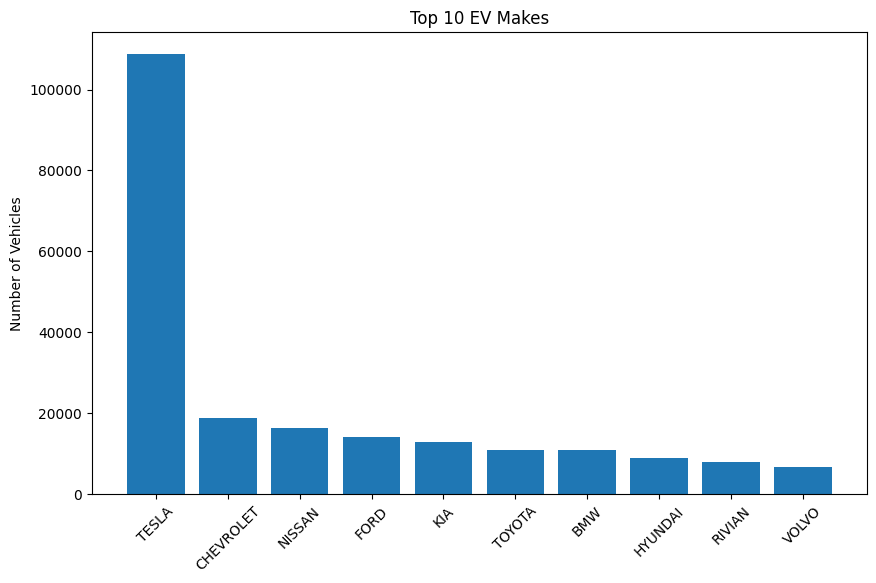

In [16]:
import matplotlib.pyplot as plt

top_makes = cleaned.groupBy('make').count().orderBy('count', ascending=False).limit(10).toPandas()

plt.figure(figsize=(10,6))
plt.bar(top_makes['make'], top_makes['count'])
plt.title("Top 10 EV Makes")
plt.xticks(rotation=45)
plt.ylabel("Number of Vehicles")
plt.show()

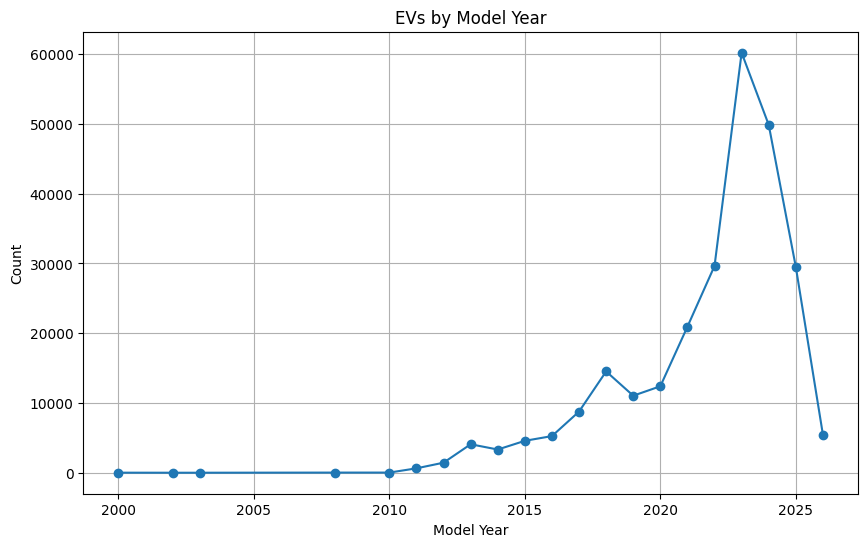

In [17]:
year_counts = cleaned.groupBy('model_year').count().orderBy('model_year').toPandas()

plt.figure(figsize=(10,6))
plt.plot(year_counts['model_year'], year_counts['count'], marker='o')
plt.title("EVs by Model Year")
plt.xlabel("Model Year")
plt.ylabel("Count")
plt.grid(True)
plt.show()

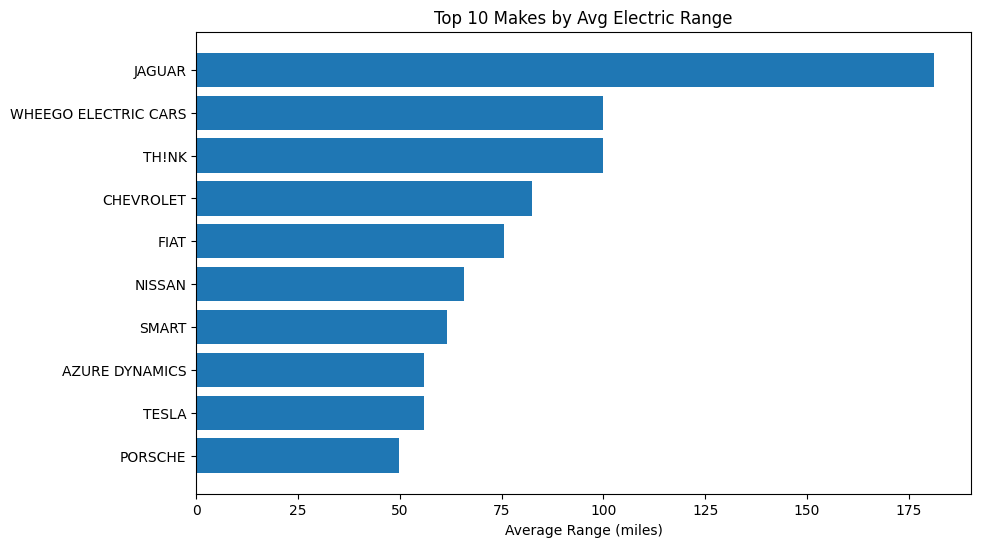

In [18]:
avg_range = cleaned.groupBy('make').avg('electric_range') \
    .withColumnRenamed('avg(electric_range)', 'avg_range') \
    .orderBy('avg_range', ascending=False).limit(10).toPandas()

plt.figure(figsize=(10,6))
plt.barh(avg_range['make'], avg_range['avg_range'])
plt.title("Top 10 Makes by Avg Electric Range")
plt.xlabel("Average Range (miles)")
plt.gca().invert_yaxis()
plt.show()

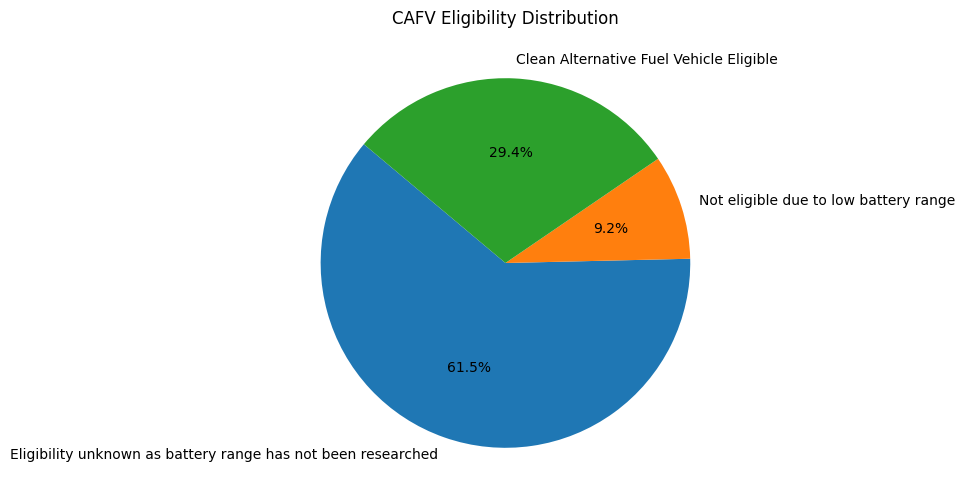

In [19]:
cafv_counts = cleaned.groupBy('cafv_eligibility').count().toPandas()

plt.figure(figsize=(8,6))
plt.pie(cafv_counts['count'], labels=cafv_counts['cafv_eligibility'], autopct='%1.1f%%', startangle=140)
plt.title("CAFV Eligibility Distribution")
plt.show()

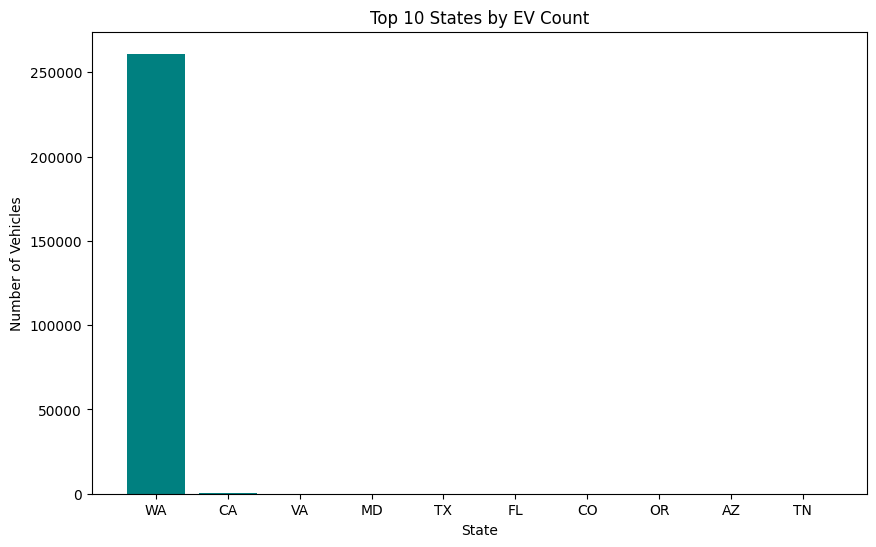

In [20]:
state_counts = cleaned.groupBy('state').count().orderBy('count', ascending=False).limit(10).toPandas()

plt.figure(figsize=(10,6))
plt.bar(state_counts['state'], state_counts['count'], color='teal')
plt.title("Top 10 States by EV Count")
plt.xlabel("State")
plt.ylabel("Number of Vehicles")
plt.show()

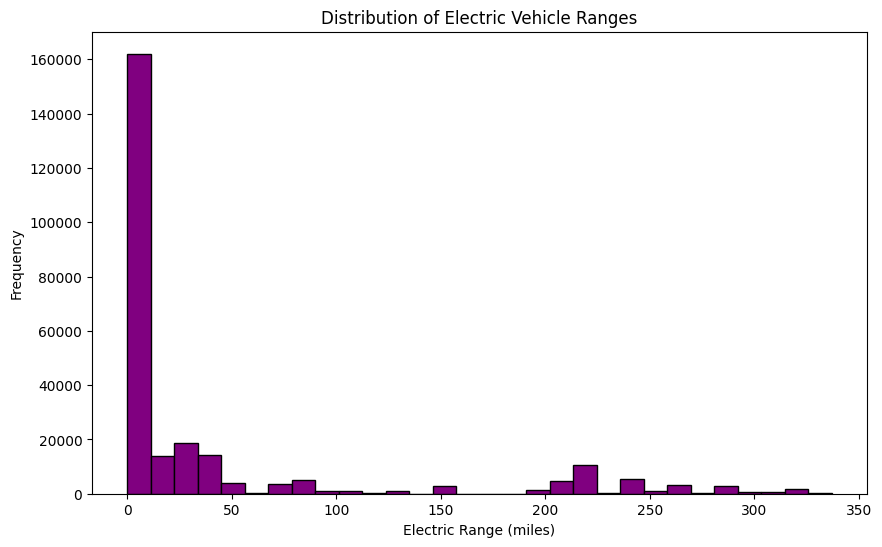

In [21]:
range_pd = cleaned.select('electric_range').dropna().toPandas()

plt.figure(figsize=(10,6))
plt.hist(range_pd['electric_range'], bins=30, color='purple', edgecolor='black')
plt.title("Distribution of Electric Vehicle Ranges")
plt.xlabel("Electric Range (miles)")
plt.ylabel("Frequency")
plt.show()

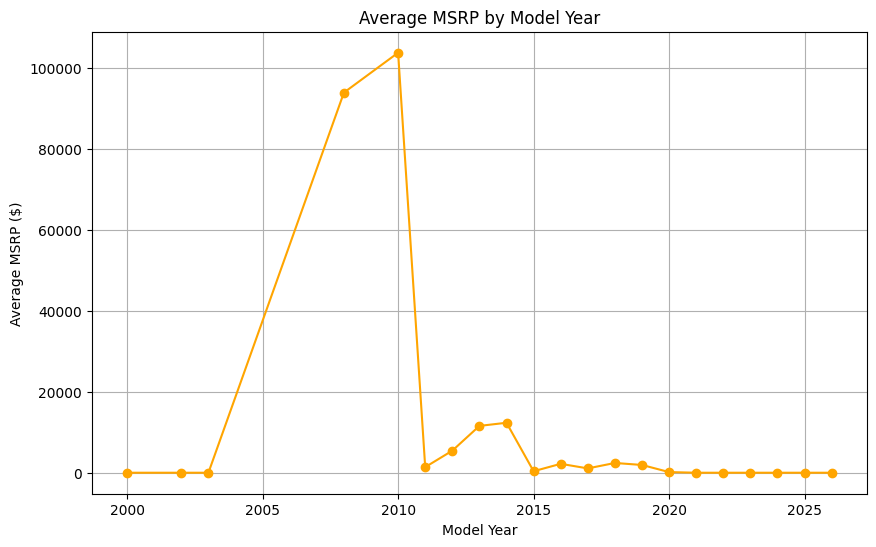

In [22]:
msrp_year = cleaned.groupBy('model_year').avg('base_msrp') \
    .withColumnRenamed('avg(base_msrp)', 'avg_msrp') \
    .orderBy('model_year').toPandas()

plt.figure(figsize=(10,6))
plt.plot(msrp_year['model_year'], msrp_year['avg_msrp'], marker='o', color='orange')
plt.title("Average MSRP by Model Year")
plt.xlabel("Model Year")
plt.ylabel("Average MSRP ($)")
plt.grid(True)
plt.show()

### Conclusion

This dataset provides a robust foundation for analyzing EV adoption trends, technological progress, and policy impact. Its size and coverage make it suitable for **predictive modeling, infrastructure planning, and market analysis**. Insights drawn can guide manufacturers, policymakers, and researchers in understanding how EVs are reshaping mobility and sustainability efforts.